# Models

In [1]:
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import reduce
import sys
import numpy
import math
numpy.set_printoptions(threshold=sys.maxsize)

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.feature_selection import RFE

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectPercentile
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc, roc_curve, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
from numpy.random import seed
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, StratifiedKFold
seed(42)
import tensorflow as tf
tf.random.set_seed(38)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense

import shap
from xgboost import plot_importance

2022-01-24 09:35:33.657740: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-24 09:35:33.657776: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# load pre porcessed data
df = pd.read_csv('../prepross_data/data.csv')


#### Filterout the paper described patient set

In [3]:
# filter dataset as describe in paper
def get_filter_by_age_diabDur(df, age, diabDur):
    filter_patients = df[(df["AgeAtConsent"] >= age) & (df["diagDuration"] > diabDur)] 
#     filter_patients=filter_patients.drop_duplicates(subset="PtID",keep="first") 
    print(f'Number of patients whos age is {age}+ and diabetics duration greater than {diabDur}  is -> {filter_patients.PtID.size}')
    return filter_patients

df = get_filter_by_age_diabDur(df, 26, 2)

Number of patients whos age is 26+ and diabetics duration greater than 2  is -> 7155


In [4]:
# remove all unknown data
df.drop(df[df.SHSeizComaPast12mos == 2].index, inplace=True)
# df.drop(df[df.Pt_SevHypoEver == 2].index, inplace=True)

### for SH events prediction pre processing


In [5]:
# check patients count with SHSeizComaPast12mos and not Pt_SevHypoEver
# df.loc[(df['SHSeizComaPast12mos']==0) & (df['Pt_SevHypoEver']==1)]

In [6]:
y_label = 'SHSeizComaPast12mos' 
# possible labels Pt_SevHypoEver, SHSeizComaPast12mos, DKAPast12mos, Depression, DiabNeuro, DKADiag

In [7]:
# fill null value according to the other parameters

# fill with 0 - if data not available probably patient has not that medical condition
def fill_y_label(row):

    if(math.isnan(row['SHSeizComaPast12mos'])):
        if((row['NumSHSeizComaPast12mos'] >= 1)):
            row[y_label] = 0
        else:
            row[y_label] = 1
    return row


df = df.apply(fill_y_label, axis=1)


In [8]:
# get possible values in column including nan
def get_possible_vals_with_nan(df, colName):
    list_val =df[colName].unique().tolist()
    return list_val


# {'1.Yes': 0, '2.No': 1, "3.Don't know": 2}

print(get_possible_vals_with_nan(df, y_label))


[1.0, 0.0]


In [9]:
pd.options.display.max_rows = 100

def get_missing_val_percentage(df):
    return (df.isnull().sum()* 100 / len(df))


missing_per = get_missing_val_percentage(df)

# get missing values < threshold feature name list
variables = df.columns
thresh = 40
variable = [ ]
var = []
for i in range(df.columns.shape[0]):
    if missing_per[i]<= thresh: #setting the threshold as 40%
        variable.append(variables[i])
    else :
        var.append(variables[i])
        
print("variables missing vals < threshold")     
print(variable)
print("Length: ", len(variable))

print()
print("variables missing vals > threshold")     
print(var)
print("Length: ", len(var))

variables missing vals < threshold
['PtID', 'Pt_InitTrt', 'Pt_SevHypoEver', 'Pt_HospDKASinceDiag', 'Pt_NumHospDKA', 'Pt_InsulinRecMethod', 'Pt_InsLev1PerDay', 'Pt_InsLev2PerDay', 'Pt_InsLant1PerDay', 'Pt_InsLant2PerDay', 'Pt_InsUnk', 'Pt_MealBolusMethod', 'Pt_InsCarbRat', 'Pt_InsCarbRatBrkfst', 'Pt_InsCarbRatLunch', 'Pt_InsCarbRatDinn', 'Pt_BolusDecCntCarb', 'Pt_BolusDaySnackFreq', 'Pt_BedtimeSnack', 'Pt_ChkBldSugPriBolus', 'Pt_MissInsDoseFreq', 'Pt_NumBolusDayUnk', 'Pt_InjLongActDayNotUsed', 'Pt_InjShortActDayNotUsed', 'Pt_LongActInsDayNotUsed', 'Pt_NumMeterCheckDay', 'Pt_DLoadHGMFreq', 'Pt_LogBook', 'Pt_ChkKetones', 'Pt_CGMUse', 'Pt_CGMStopUse', 'Pt_LastEyeExamPart', 'Pt_DiabRetTrtPart', 'Pt_LegBlind', 'Pt_HealthProfDiabEdu', 'Pt_GlutFreeDiet', 'Pt_CeliacDr', 'Pt_HighBldPrTrt', 'Pt_Smoke', 'Pt_GenHealth', 'Pt_StressDiab', 'Pt_AnnualInc', 'Pt_HouseholdCnt', 'Pt_InsPriv', 'Pt_MaritalStatus', 'Pt_EmployStatus', 'Pt_RaceEth', 'HyperglyCritHbA1c', 'HyperglyCritRandGluc', 'ReqInsulinCrit',

In [10]:
# cols_to_del = ['Diab_dur_greater','HbA1C_SH', 'Pt_InsHumalog', 'Pt_InsNovolog', 'Pt_BolusDecCntCarb', 
#                'Pt_BolusBedtimeSnackFreq', 'Pt_InsPumpStartAge', 'Pt_PumpManuf', 'Pt_PumpModel',
#                'Pt_DaysLeavePumpIns', 'Pt_BasInsRateChgDay', 'Pt_NumBolusDay', 'Pt_ReturnPump', 
#                'Pt_InjMethod', 'Pt_InjLongActDay', 'Pt_InjShortActDay', 'Pt_LongActInsDay', 
#                'Pt_ShortActInsDay', 'Pt_PumpStopUse', 'Pt_HealthProfDiabEdu', 'Pt_SmokeAmt', 
#                'Pt_DaysWkEx', 'Pt_MenarcheAge', 'Pt_RegMenstCyc', 'Pt_IrregMenstCycReas',
#                'Pt_CurrPreg', 'Pt_MiscarriageNum', 'Pt_v3NumHospOthReas',
#                'HyperglyCritRandGluc', 'WeightDiag', 'NumDKAOccur', 'TannerNotDone', 'PumpTotBasIns',
#                'HGMNumDays', 'HGMTestCntAvg', 'HGMGlucMean', 'CGMGlucPctBelow70', 'CGMGlucPctBelow60', 
#                'PulseRate', 'InsCarbRatBrkfst', 'InsCarbRatLunch', 'InsCarbRatDinn', 'InsCarbRatDinnNotUsed', 
#                'CGMPctBelow55', 'CGMPctBelow80']

cols_to_del = ['Diab_dur_greater', 'ExamDaysFromConsent']

df.drop(cols_to_del, inplace=True, axis=1)
df.head(10)

,PtID,Pt_InitTrt,Pt_SevHypoEver,Pt_HospDKASinceDiag,Pt_NumHospDKA,Pt_InsulinRecMethod,Pt_InsLev1PerDay,Pt_InsLev2PerDay,Pt_InsLant1PerDay,Pt_InsLant2PerDay,...,CardiacArrhyth,Hemoglob,RheumArth,Osteo,Depression,Anxiety,Psychosis,DiabNeuro,diagDuration,education_level
0,3963.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0876,11.0
4,12505.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.1684,12.0
7,26063.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0507,NaN
14,553.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.8549,11.0
15,13365.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.3915,13.0
20,15799.0,3.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.1739,9.0
24,15966.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0999,12.0
27,6426.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.1704,10.0
34,10659.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.9979,10.0
40,19861.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,42.6872,10.0


In [11]:
# gender specific data
# number of F and M
# check gender distribution of selected dataset  Gender {'F': 0, 'M': 1, 'T': 2}

gender_groupby = df.groupby('Gender', as_index=False).agg(total= ('PtID','count'))
print(gender_groupby)

   Gender  total
0     0.0   3615
1     1.0   3038
2     2.0      2


In [12]:
# only SH event occured 
is_male = True
if is_male:
    gender_label = 1.0
else:
    gender_label = 0.0

df_sh = df[df[y_label]==0.0]
gender_groupby = df_sh.groupby('Gender', as_index=False).agg(total= ('PtID','count'))
print(gender_groupby)
print(df.shape)
df = df[df['Gender'] == 0.0]
df.shape

   Gender  total
0     0.0    106
1     1.0     99
(6655, 157)


(3615, 157)

In [13]:
def remove_gender_specific_fields(df):
    if is_male:
        drop_list = ['Pt_MenarcheAge','Pt_RegMenstCyc','Pt_IrregMenstCycReas','Pt_CurrPreg','Pt_MiscarriageNum']
        df = df.drop(drop_list, axis = 1)
        return df
    else:
        return df

df = remove_gender_specific_fields(df)

# Divide Dataset

In [14]:
df=df.drop('PtID', axis = 1)

In [15]:
def corrX_orig(df, cut = 0.8) :
        
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    drop = list()
    
    # For loop implements this pseudocode
    # For every cell in the upper triangle: 
        # If cell.value > 0.6: 
                # If mean(row_correlation) > mean(column_correlation):drop(column)
		# Else: drop(row)
        
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    drop.append(row)
                else: 
                    drop.append(col)
    
    drop_set = list(set(drop))
    dropcols_names = list(df.columns[[item for item in drop_set]])
    
    return(dropcols_names)

cols_to_drop = corrX_orig(df)


In [16]:

df.drop(['Lipoatrophy',
 'AgeAtConsent',
 'InsCarbRatDinn',
 'InsNovolog',
 'CGMGlucPctBelow60'], inplace=True, axis=1)
df.head(10)


,Pt_InitTrt,Pt_SevHypoEver,Pt_HospDKASinceDiag,Pt_NumHospDKA,Pt_InsulinRecMethod,Pt_InsLev1PerDay,Pt_InsLev2PerDay,Pt_InsLant1PerDay,Pt_InsLant2PerDay,Pt_InsUnk,...,CardiacArrhyth,Hemoglob,RheumArth,Osteo,Depression,Anxiety,Psychosis,DiabNeuro,diagDuration,education_level
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.1684,12.0
14,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.8549,11.0
20,3.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.1739,9.0
24,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0999,12.0
34,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.9979,10.0
61,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.3799,NaN
62,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,29.6249,13.0
91,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.4791,12.0
93,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3073,10.0
100,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.2854,11.0


In [17]:

def divide_data(df,label):
    Y = df[label]
    X = df.drop(label, axis=1)
    return X, Y

X, Y = divide_data(df, y_label)


In [18]:
Y.unique()

array([1., 0.])

# Feature Selection

In [19]:
shape = np.shape(X) 
feature = 25 #shape[1] 
n_classes = 2


In [20]:
seed(42)
tf.random.set_seed(38)
# Save original data set
original_X = X

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=123)
# if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)


In [21]:
len(Y_train == 0.0)
unique, counts = numpy.unique(Y_train.to_numpy(), return_counts=True)
print("Train - ", unique, counts)

unique_test, counts_test = numpy.unique(Y_test.to_numpy(), return_counts=True)
print("Test - ", unique_test, counts_test)


Train -  [0. 1.] [  79 2632]
Test -  [0. 1.] [ 27 877]


# Imputations

<AxesSubplot:>

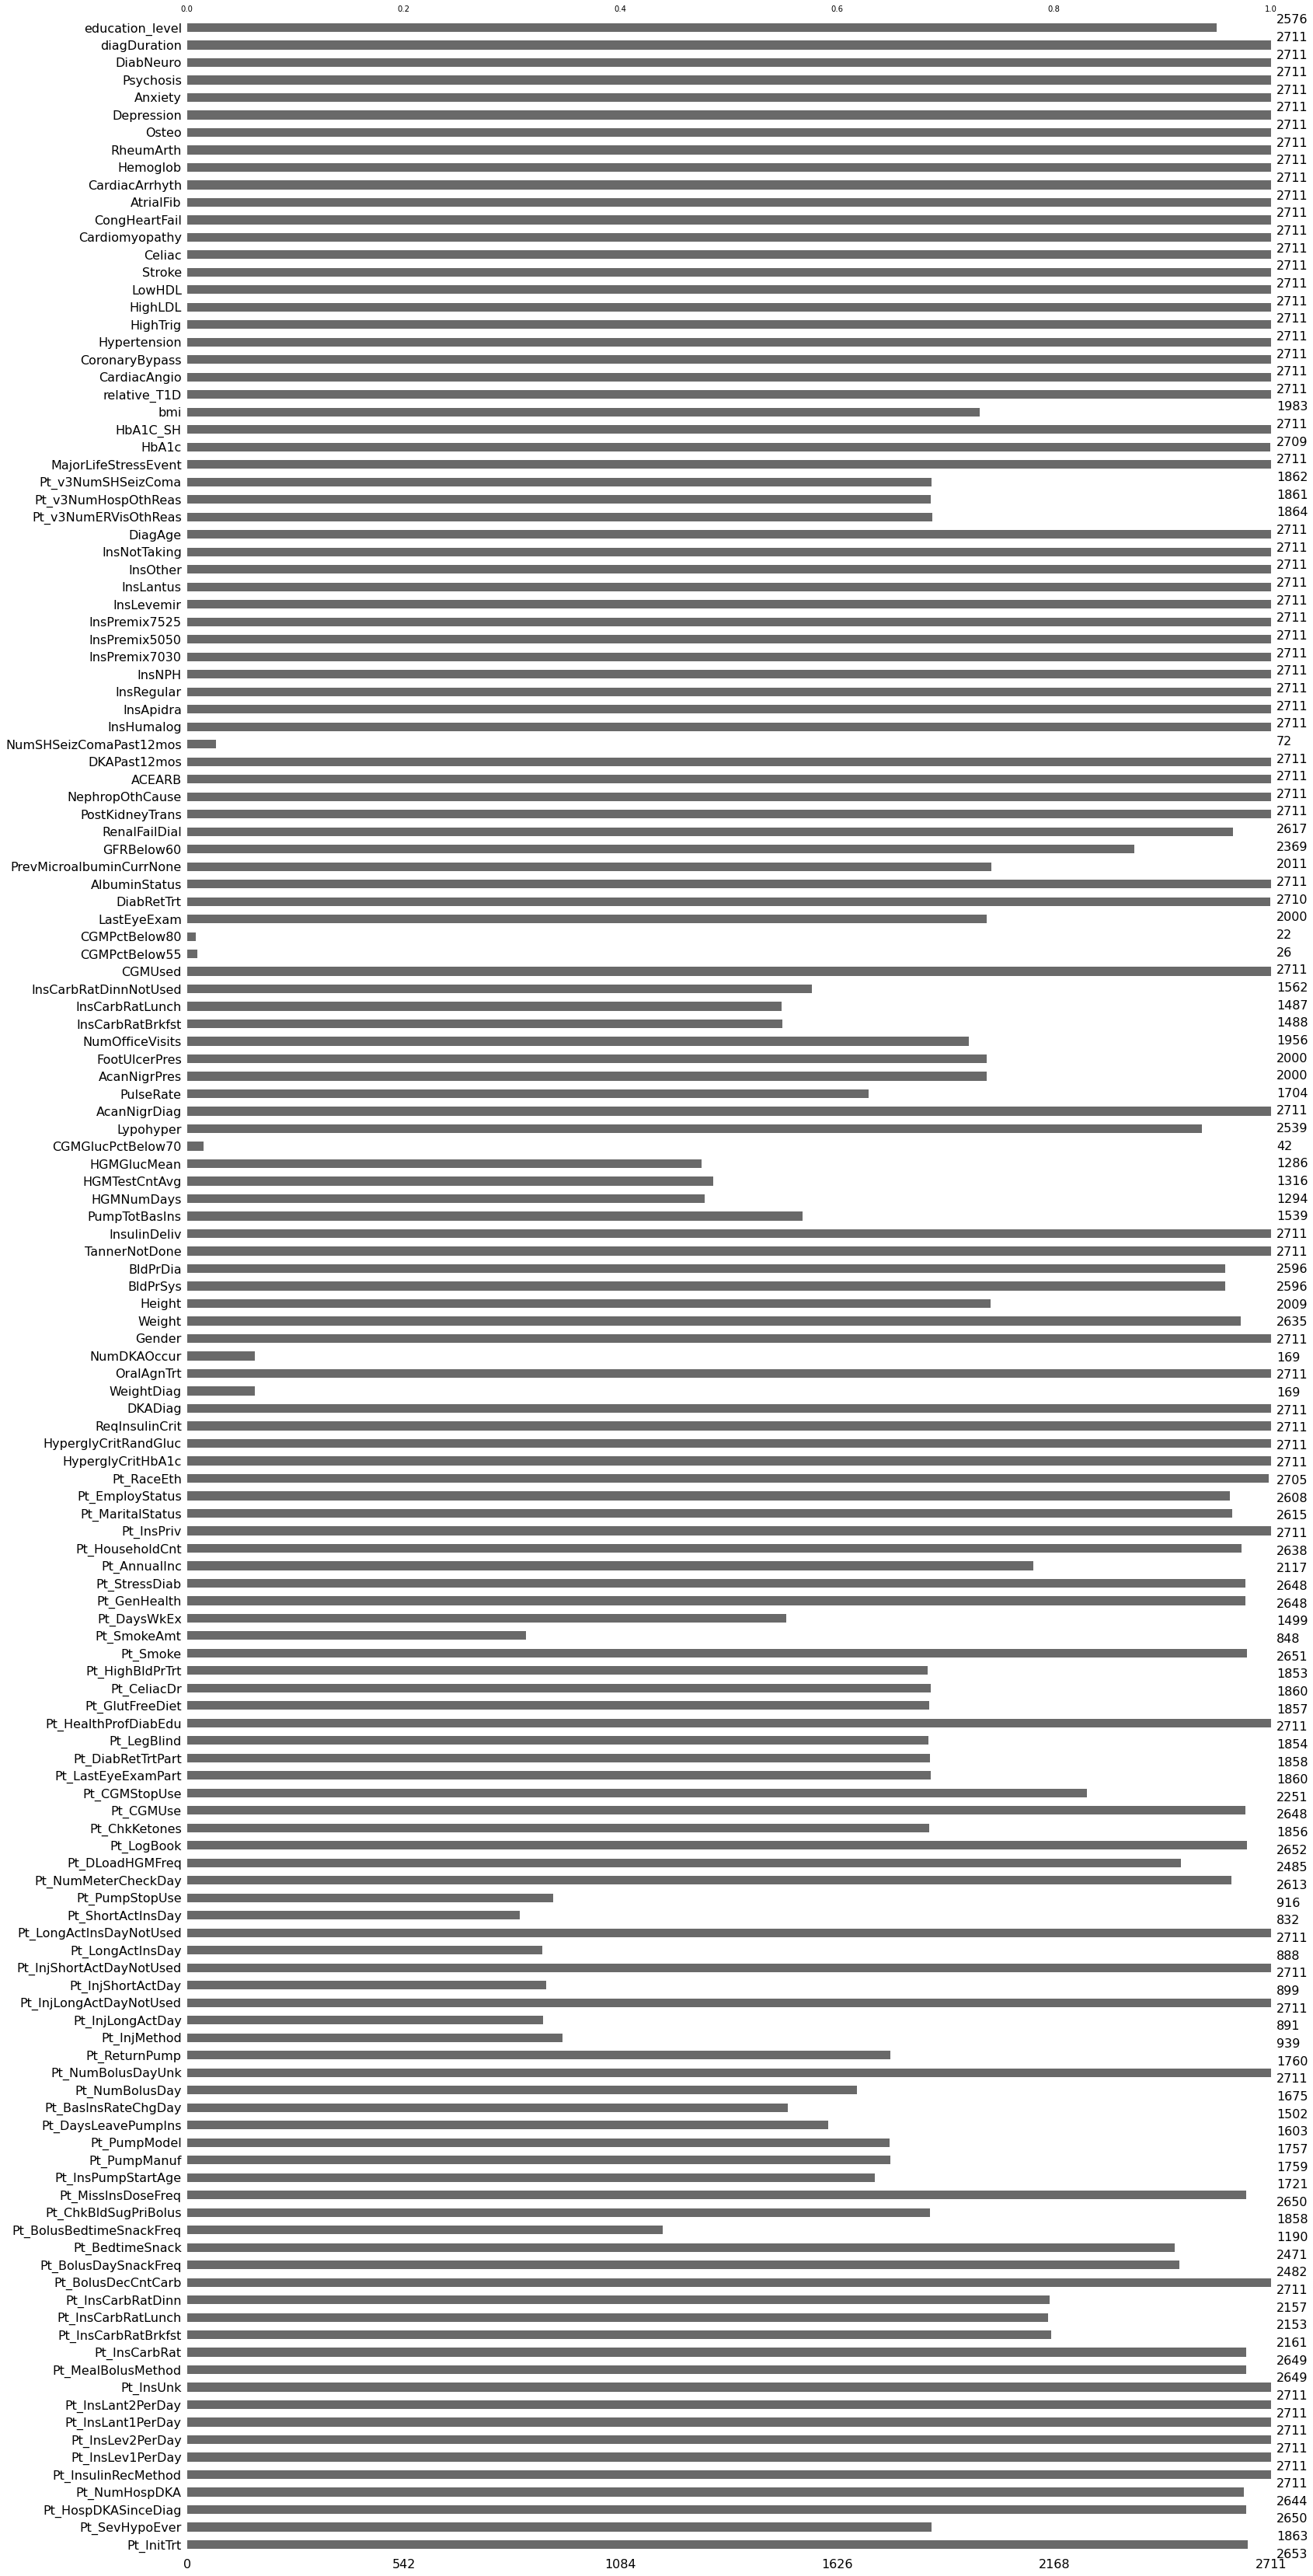

In [22]:
import missingno as msno
msno.bar(X_train)

### XGB with missing values

In [23]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [24]:
# use only for XGB classifier with missing values
# X_train_copy = X_train.drop(['SHSeizComaPast12mos', 'NumSHSeizComaPast12mos'], axis=1)
# X_test_copy = X_test.drop(['SHSeizComaPast12mos', 'NumSHSeizComaPast12mos'], axis=1)

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
if('NumSHSeizComaPast12mos' in X_train.columns):
    X_train_copy = X_train_copy.drop(['NumSHSeizComaPast12mos'], axis=1)
    X_test_copy = X_test_copy.drop([ 'NumSHSeizComaPast12mos'], axis=1)
if('Pt_v3NumSHSeizComa' in X_train.columns):
    X_train_copy = X_train_copy.drop(['Pt_v3NumSHSeizComa'], axis=1)
    X_test_copy = X_test_copy.drop(['Pt_v3NumSHSeizComa'], axis=1)
# if('Pt_SevHypoEver' in X_train.columns):
#     X_train_copy = X_train_copy.drop(['Pt_SevHypoEver'], axis=1)
#     X_test_copy = X_test_copy.drop(['Pt_SevHypoEver'], axis=1)

feature_list_m = ['Pt_InitTrt', 'Pt_SevHypoEver', 'Pt_InsCarbRatDinn',
       'Pt_BolusDaySnackFreq', 'Pt_DaysLeavePumpIns', 'Pt_NumBolusDay',
       'Pt_InjShortActDay', 'Pt_LongActInsDay', 'Pt_StressDiab',
       'ReqInsulinCrit', 'WeightDiag', 'TannerNotDone', 'HGMNumDays',
       'Lypohyper', 'AcanNigrDiag', 'NumOfficeVisits', 'InsCarbRatBrkfst',
       'InsCarbRatDinnNotUsed', 'CGMPctBelow55', 'GFRBelow60',
        'InsOther', 'Pt_v3NumHospOthReas',
        'diagDuration']

feature_list_f =['Pt_SevHypoEver', 'Pt_NumHospDKA', 'Pt_InsCarbRatBrkfst',
       'Pt_InsCarbRatDinn', 'Pt_InsPumpStartAge', 'Pt_PumpModel',
       'Pt_DaysLeavePumpIns', 'Pt_NumMeterCheckDay', 'Pt_DLoadHGMFreq',
       'Pt_LastEyeExamPart', 'Pt_DiabRetTrtPart', 'Pt_GlutFreeDiet',
       'Pt_HighBldPrTrt', 'Pt_GenHealth', 'Pt_RaceEth', 'HyperglyCritHbA1c',
       'ReqInsulinCrit', 'Height', 'NumOfficeVisits', 'InsCarbRatDinnNotUsed',
       'AlbuminStatus', 'DKAPast12mos',
        'diagDuration']

# feature_list = ['Pt_InitTrt', 'Pt_SevHypoEver', 'Pt_HospDKASinceDiag',
#        'Pt_InsLev1PerDay', 'Pt_InsLant2PerDay', 'Pt_InsCarbRatDinn',
#        'Pt_PumpManuf', 'Pt_DaysLeavePumpIns', 'Pt_ChkKetones',
#        'Pt_HighBldPrTrt', 'Pt_InsPriv', 'WeightDiag', 'HGMNumDays',
#        'Lypohyper', 'AcanNigrDiag', 'AcanNigrPres', 'NumOfficeVisits',
#        'InsCarbRatLunch', 'LastEyeExam', 'AlbuminStatus', 'RenalFailDial',
#         'CardiacAngio',
#        'diagDuration']
# X_train_copy = X_train_copy[feature_list]
# X_test_copy = X_test_copy[feature_list]
    

In [25]:
kf = KFold(n_splits= 10, shuffle=False)
train = X_train_copy.copy()
train[y_label] = Y_train.values



from sklearn.model_selection import LeaveOneOut

cv = LeaveOneOut()




def cross_val_with_missing_val(model,n_splits=5):
#     i = 1
#     for train_index, test_index in kf.split(train):
#         X_train1 = train.iloc[train_index].loc[:, X_train_copy.columns]
#         X_test1 = train.iloc[test_index][X_train_copy.columns]
#         y_train1 = train.iloc[train_index].loc[:,y_label]
#         y_test1 = train.iloc[test_index][y_label]

#         #Train the model
#         model.fit(X_train1, y_train1) #Training the model
#         print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}")
#         i += 1
#     return model


    

    dfs = []
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train_copy.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train_copy.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        
        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")

        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1






#     dfs = []
#     y_true, y_pred = list(), list()
#     for train_index, test_index in cv.split(train, Y_train):

#         X_train1 = train.iloc[train_index].loc[:, X_train_copy.columns]
#         X_test1 = train.iloc[test_index].loc[:,X_train_copy.columns]
#         y_train1 = train.iloc[train_index].loc[:,y_label]
#         y_test1 = train.iloc[test_index].loc[:,y_label]

# #         Train the model
#         model.fit(X_train1, y_train1) #Training the model

    return model



Accuracy for the fold no. 1 on the test set: 0.9705882352941176, doublecheck: 0.9705882352941176
Accuracy for the fold no. 2 on the test set: 0.974169741697417, doublecheck: 0.974169741697417
Accuracy for the fold no. 3 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 4 on the test set: 0.974169741697417, doublecheck: 0.974169741697417
Accuracy for the fold no. 5 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 6 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 7 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 8 on the test set: 0.966789667896679, doublecheck: 0.966789667896679
Accuracy for the fold no. 9 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 10 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479

 
 ===========   Train Dataset    

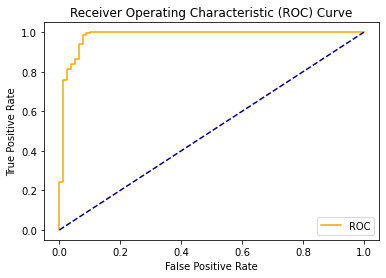

accuracy score:  98.59830320914791
              precision    recall  f1-score   support

         0.0       0.70      0.92      0.79        79
         1.0       1.00      0.99      0.99      2632

    accuracy                           0.99      2711
   macro avg       0.85      0.96      0.89      2711
weighted avg       0.99      0.99      0.99      2711



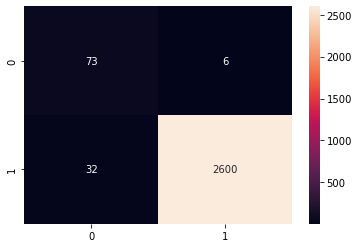

Accuracy of XGB on training set: 1.00


 ===========   Test Dataset    =============
Threshold value is: 2.8033738


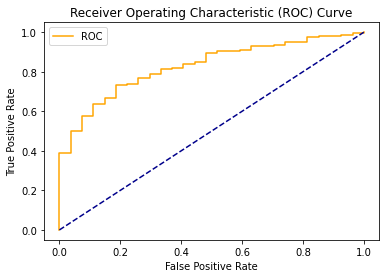

accuracy score:  73.78318584070797
              precision    recall  f1-score   support

         0.0       0.09      0.81      0.16        27
         1.0       0.99      0.74      0.84       877

    accuracy                           0.74       904
   macro avg       0.54      0.78      0.50       904
weighted avg       0.97      0.74      0.82       904



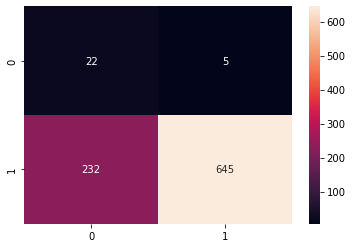

Accuracy of XGB classifier on test set: 0.97


 ===========   ROC    =============
roc_auc = 0.828


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.81481481 0.7354618 ]
average accuracy:  0.7751383082055829
f1 0.8447937131630648


In [26]:
# xgboost - train with missing values

model=XGBClassifier(
        use_label_encoder=False, eta = 0.1,#eta between(0.01-0.2)
        max_depth = 4, #values between(3-10)
        max_delta_step = 10,
#         scale_pos_weight = 0.4,
#         n_jobs = 0,
#         subsample = 0.5,#values between(0.5-1)
#         colsample_bytree = 1,#values between(0.5-1)
#         tree_method = "auto",
#         process_type = "default",
#         num_parallel_tree=7,
#         objective = 'binary:logistic', 
        objective='multi:softmax',
#         min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
    )

# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model, 10)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))


print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)


print('f1', metrics.f1_score(xgb_pred, Y_test))


<AxesSubplot:>

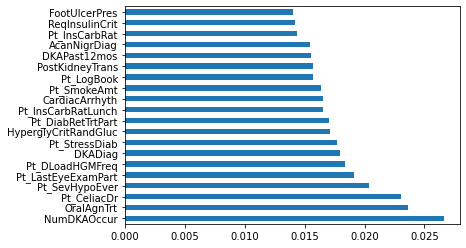

In [27]:
# feature importance graph of XGB
feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:204])
feat_importances.nlargest(20).plot(kind='barh')


Accuracy for the fold no. 1 on the test set: 0.9705882352941176, doublecheck: 0.9705882352941176
Accuracy for the fold no. 2 on the test set: 0.974169741697417, doublecheck: 0.974169741697417
Accuracy for the fold no. 3 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 4 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 5 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 6 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 7 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 8 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 9 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 10 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479

 
 ===========   Train Dataset

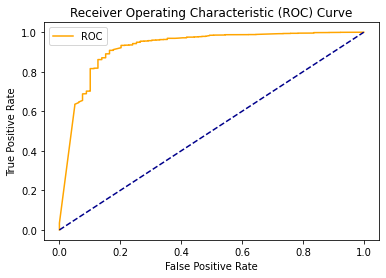

accuracy score:  90.63076355588345
              precision    recall  f1-score   support

         0.0       0.21      0.84      0.34        79
         1.0       0.99      0.91      0.95      2632

    accuracy                           0.91      2711
   macro avg       0.60      0.87      0.65      2711
weighted avg       0.97      0.91      0.93      2711



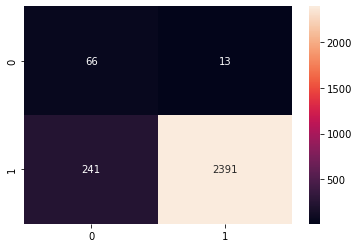

Accuracy of XGB on training set: 0.97


 ===========   Test Dataset    =============
Threshold value is: 0.9718739769510151


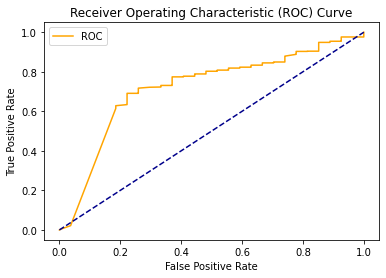

accuracy score:  69.35840707964603
              precision    recall  f1-score   support

         0.0       0.07      0.78      0.13        27
         1.0       0.99      0.69      0.81       877

    accuracy                           0.69       904
   macro avg       0.53      0.73      0.47       904
weighted avg       0.96      0.69      0.79       904



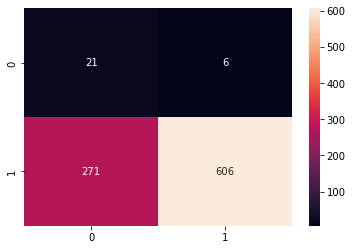



 ===========   ROC    =============
roc_auc = 0.7203


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.77777778 0.69099202]
average accuracy:  0.7343848980108958
f1 0.8139691067830759


In [28]:

import lightgbm as ltb

# xgboost - train with missing values

model=ltb.LGBMClassifier(use_missing = True,
                         learning_rate = 0.001, 
                         max_depth =5, random_state=0 )
                   
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model,10)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))


print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

# test_acc = model.score(X_test_copy, Y_test)
# print('Accuracy of XGB classifier on test set: {:.2f}'
#      .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)


print('f1', metrics.f1_score(xgb_pred, Y_test))

<AxesSubplot:>

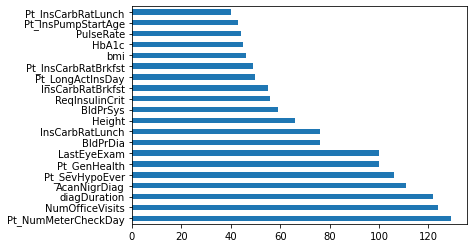

In [29]:
# feature importance graph of XGB
feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:204])
feat_importances.nlargest(20).plot(kind='barh')


In [30]:
if is_male:
    
    X_train.update(X_train[[
                 'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
                 'HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
                 'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
                 ]].fillna(0))

    X_test.update(X_test[[
                 'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
                 'HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
                 'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
                 ]].fillna(0))
else:
    X_train.update(X_train[[
             'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
             'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
             'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
             ]].fillna(0))

    X_test.update(X_test[[
             'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
             'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
             'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
             ]].fillna(0))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [31]:
# fill nan values in categorical dataset with frequent value

# tested wuth mean and median - results is lower than most_frequent
# imputeX = SimpleImputer(missing_values=np.nan, strategy = "most_frequent")
# imputeX = KNNImputer(missing_values=np.nan, n_neighbors = 3, weights='distance')
imputeX = IterativeImputer(missing_values=np.nan,sample_posterior= True,max_iter=15,
                           initial_strategy='most_frequent', random_state=0)

X_train = imputeX.fit_transform(X_train)


In [32]:
# ###############
# import datawig

# imputer = datawig.SimpleImputer()
# imputer.fit(train_df = X_train, num_epochs=50)
# X_test = imputer.predict(X_test)
# X_train = imputer.predict(X_train)

In [33]:
# test data imputation

Test = X_test.copy()
Test.loc[:,y_label] = Y_test

X_test = imputeX.transform(X_test)



# Scale data

In [34]:
# Normalize numeric features
scaler = StandardScaler()
# scaler = MinMaxScaler()
select = {}
select[0] = pd.DataFrame(scaler.fit_transform(X_train))
select[1] = Y_train
select[2] = pd.DataFrame(scaler.transform(X_test))


## Feature Selection

In [35]:
# TODO

# def select_features(select, feature):
#     selected = {}
#     fs = SelectKBest(score_func=mutual_info_classif, k=feature) # k=feature score_func SelectPercentile
#     selected[0] = fs.fit_transform(select[0], select[1])
#     selected[1] = fs.transform(select[2])
        
#     idx = fs.get_support(indices=True)
    
#     return selected, fs, idx



In [36]:


#Selecting the Best important features according to Logistic Regression
# Give better performance than selectKBest 
def select_features(select, feature):
    selected = {}
#     fs = RFE(estimator=LogisticRegression(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    fs = RFE(estimator=XGBClassifier(), n_features_to_select=feature, step = 5) #  step (the number of features eliminated each iteration) 
#     fs = RFE(estimator=RandomForestClassifier(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    
    
    selected[0] = fs.fit_transform(select[0], select[1])
    selected[1] = fs.transform(select[2])
        
    idx = fs.get_support(indices=True)
    
    return selected, fs, idx


In [37]:
# Feature selection
selected, fs, idx = select_features(select, feature)


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:39:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [38]:
# Get columns to keep and create new dataframe with those only
from pprint import pprint
cols = fs.get_support(indices=True)
features_df_new = original_X.iloc[:,cols]
pprint(features_df_new.columns)
print(features_df_new.shape)



Index(['Pt_SevHypoEver', 'Pt_InsLant2PerDay', 'Pt_InsCarbRatBrkfst',
       'Pt_ChkBldSugPriBolus', 'Pt_PumpModel', 'Pt_DLoadHGMFreq', 'Pt_CGMUse',
       'Pt_DiabRetTrtPart', 'Pt_HighBldPrTrt', 'Pt_DaysWkEx', 'Pt_GenHealth',
       'Pt_RaceEth', 'HyperglyCritHbA1c', 'NumDKAOccur', 'BldPrDia',
       'HGMNumDays', 'HGMGlucMean', 'AcanNigrDiag', 'NumOfficeVisits',
       'CGMUsed', 'DKAPast12mos', 'NumSHSeizComaPast12mos', 'DiagAge',
       'Pt_v3NumSHSeizComa', 'diagDuration'],
      dtype='object')
(3615, 25)


In [39]:
X_train = pd.DataFrame(selected[0], columns = features_df_new.columns)
X_test = pd.DataFrame(selected[1], columns = features_df_new.columns)


In [40]:
# X_train.drop(['Pt_v3NumSHSeizComa', 'SHSeizComaPast12mos'], inplace=True, axis=1)
# X_test.drop(['Pt_v3NumSHSeizComa', 'SHSeizComaPast12mos'], inplace=True, axis=1)

# if('Pt_SevHypoEver' in X_train.columns):
#     X_train = X_train.drop(['Pt_SevHypoEver'], axis=1)
#     X_test = X_test.drop(['Pt_SevHypoEver'], axis=1)
if('NumSHSeizComaPast12mos' in X_train.columns):
    X_train = X_train.drop(['NumSHSeizComaPast12mos'], axis=1)
    X_test = X_test.drop([ 'NumSHSeizComaPast12mos'], axis=1)
if('Pt_v3NumSHSeizComa' in X_train.columns):
    X_train = X_train.drop(['Pt_v3NumSHSeizComa'], axis=1)
    X_test = X_test.drop(['Pt_v3NumSHSeizComa'], axis=1)


### Common functions

In [41]:
# kf = KFold(n_splits= 3, shuffle=False)
train = X_train.copy()
train[y_label] = Y_train.values

def cross_val(model, n_splits=10):
#     i = 1
#     for train_index, test_index in kf.split(train):
#         X_train1 = train.iloc[train_index].loc[:, X_train.columns]
#         X_test1 = train.iloc[test_index][X_train.columns]
#         y_train1 = train.iloc[train_index].loc[:,y_label]
#         y_test1 = train.iloc[test_index][y_label]

#         #Train the model
#         model.fit(X_train1, y_train1) #Training the model
#         print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}")
#         i += 1
#     return model



    dfs = []
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")

        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1
    return model



In [42]:
def optimal_thresh(model, X, Y):
    y_scores = model.predict_proba(X)[:,1]

    fpr, tpr, thresholds = roc_curve(Y, y_scores)
    print(roc_auc_score(Y, y_scores))
#     optimal_idx = np.argmax(sqrt(tpr * (1-fpr)))
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    plot_roc_curve(fpr, tpr)
    plt.show()
    return optimal_threshold

In [43]:
def train_results(model, X_train, Y_train, pred_train):
    print("\n \n =====================   Train Dataset    ======================")

    print(accuracy_score(Y_train, pred_train)*100)

    confusion_matrix_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
    sns.heatmap(confusion_matrix_train, annot=True,fmt='g')
    print(classification_report(Y_train, pred_train))
    plt.show()
    
    train_acc = model.score(X_train, Y_train)
    print('Accuracy of on training set: {:.2f}'.format(train_acc))

def test_results(model, X_test, Y_test, pred):
    print("\n\n =====================   Test Dataset    =======================")

    print(accuracy_score(Y_test, pred)*100)

    confusion_matrix_model = confusion_matrix(Y_test, pred)
    sns.heatmap(confusion_matrix_model, annot=True,fmt='g')
    print(classification_report(Y_test, pred))
    plt.show()
    
    test_acc = model.score(X_test, Y_test)
    print('Accuracy of classifier on test set: {:.2f}'
         .format(test_acc))

def ROC_results(model, X_test, Y_test):
    print("\n\n =======================   Test-ROC    =========================")

    y_scores = model.predict_proba(X_test)
    score = roc_auc_score(Y_test, y_scores[:, 1])
    score = round(score,4)
    print(f'roc_auc = {score}')
    
def class_wise_test_accuracy(model, Y_test, pred):
    print("\n\n =======================   Class-wise test accuracy    =====================")
    confusion_matrix_model = confusion_matrix(Y_test, pred)
    acc = confusion_matrix_model.diagonal()/confusion_matrix_model.sum(axis=1)
    print('classwise accuracy [class 0, class 1]: ',(acc))
    print('average accuracy: ',( np.sum(acc)/2))
    
    print('f1', metrics.f1_score(pred, Y_test))    

Accuracy for the fold no. 1 on the test set: 0.9705882352941176, doublecheck: 0.9705882352941176
Accuracy for the fold no. 2 on the test set: 0.974169741697417, doublecheck: 0.974169741697417
Accuracy for the fold no. 3 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 4 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 5 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 6 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 7 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 8 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 9 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 10 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Train ROC
0.9089155861644415
Th

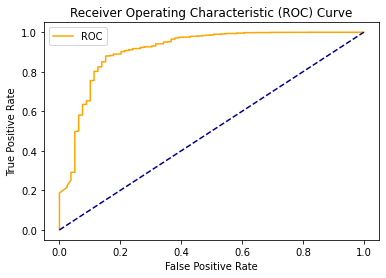

Test ROC
0.7538536255754044
Threshold value is: 0.9669719072160177


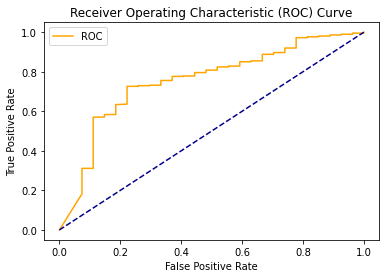


 
 =====================   Train Dataset    ======================
87.90114348948728
              precision    recall  f1-score   support

         0.0       0.17      0.85      0.29        79
         1.0       0.99      0.88      0.93      2632

    accuracy                           0.88      2711
   macro avg       0.58      0.86      0.61      2711
weighted avg       0.97      0.88      0.92      2711



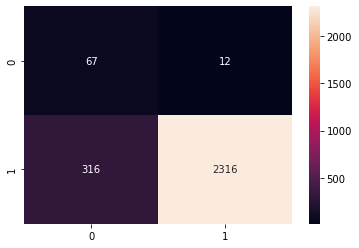

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
72.78761061946902
              precision    recall  f1-score   support

         0.0       0.08      0.78      0.15        27
         1.0       0.99      0.73      0.84       877

    accuracy                           0.73       904
   macro avg       0.54      0.75      0.49       904
weighted avg       0.96      0.73      0.82       904



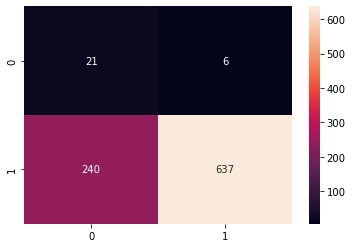

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.7539


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.77777778 0.72633979]
average accuracy:  0.752058786266312
f1 0.8381578947368422


In [59]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

ltb_model=ltb.LGBMClassifier(use_missing = False,
                         learning_rate = 0.01, 
                         max_depth =4, random_state=0 )
# adaboost.fit(X_train, Y_train)
ltb_model = cross_val(ltb_model, 10)

# pred=adaboost.predict(X_test)
# pred_train=adaboost.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(ltb_model, X_train, Y_train)
pred_train = (ltb_model.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)
print("Test ROC")
optimal_threshold = optimal_thresh(ltb_model, X_test, Y_test)
pred = (ltb_model.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# test and train results
train_results(ltb_model, X_train, Y_train, pred_train)
test_results(ltb_model, X_test, Y_test, pred)

# ROC
ROC_results(ltb_model, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(ltb_model, Y_test, pred)


<AxesSubplot:>

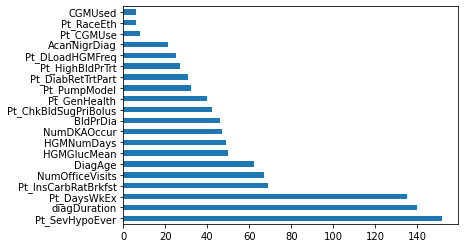

In [45]:
feat_importances = pd.Series(ltb_model.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

### Adaboost model

Accuracy for the fold no. 1 on the test set: 0.9705882352941176, doublecheck: 0.9705882352941176
Accuracy for the fold no. 2 on the test set: 0.974169741697417, doublecheck: 0.974169741697417
Accuracy for the fold no. 3 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 4 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 5 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 6 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 7 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 8 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 9 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 10 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Train ROC
0.8595523450425148
Th

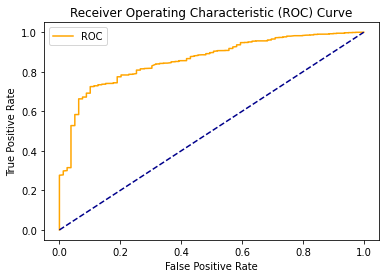

Test ROC
0.7250517336036151
Threshold value is: 0.6099742223261031


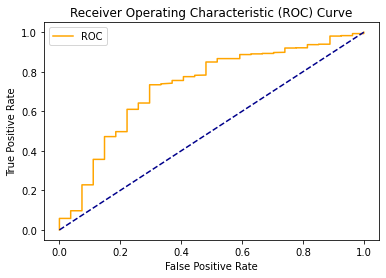


 
 =====================   Train Dataset    ======================
72.99889339727038
              precision    recall  f1-score   support

         0.0       0.09      0.90      0.16        79
         1.0       1.00      0.72      0.84      2632

    accuracy                           0.73      2711
   macro avg       0.54      0.81      0.50      2711
weighted avg       0.97      0.73      0.82      2711



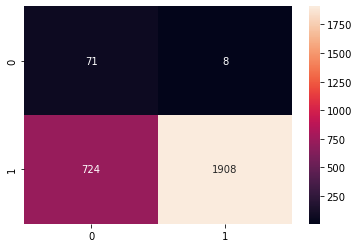

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
73.34070796460178
              precision    recall  f1-score   support

         0.0       0.08      0.70      0.14        27
         1.0       0.99      0.73      0.84       877

    accuracy                           0.73       904
   macro avg       0.53      0.72      0.49       904
weighted avg       0.96      0.73      0.82       904



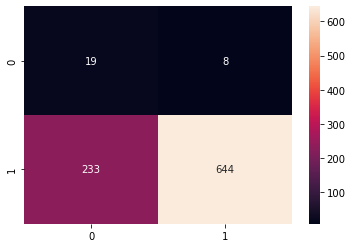

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.7251


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.7037037  0.73432155]
average accuracy:  0.7190126272224333
f1 0.842380640941792


In [46]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

adaboost = AdaBoostClassifier(random_state=0, learning_rate=0.008, n_estimators=1000, algorithm = "SAMME.R") #algorithm{‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’

# adaboost.fit(X_train, Y_train)
adaboost = cross_val(adaboost, 10)

# pred=adaboost.predict(X_test)
# pred_train=adaboost.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(adaboost, X_train, Y_train)
pred_train = (adaboost.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)
print("Test ROC")
optimal_threshold = optimal_thresh(adaboost, X_test, Y_test)
pred = (adaboost.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# test and train results
train_results(adaboost, X_train, Y_train, pred_train)
test_results(adaboost, X_test, Y_test, pred)

# ROC
ROC_results(adaboost, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(adaboost, Y_test, pred)


<AxesSubplot:>

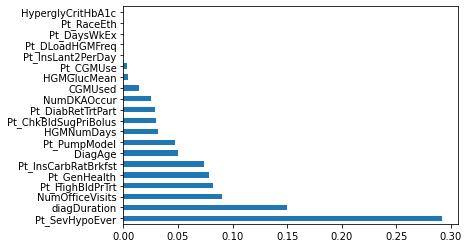

In [47]:
feat_importances = pd.Series(adaboost.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

# Model - XGB

Accuracy for the fold no. 1 on the test set: 0.9705882352941176, doublecheck: 0.9705882352941176
Accuracy for the fold no. 2 on the test set: 0.974169741697417, doublecheck: 0.974169741697417
Accuracy for the fold no. 3 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 4 on the test set: 0.966789667896679, doublecheck: 0.966789667896679
Accuracy for the fold no. 5 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 6 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 7 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 8 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 9 on the test set: 0.966789667896679, doublecheck: 0.966789667896679
Accuracy for the fold no. 10 on the test set: 0.974169741697417, doublecheck: 0.974169741697417
Train ROC
0.963347889654111
Threshold

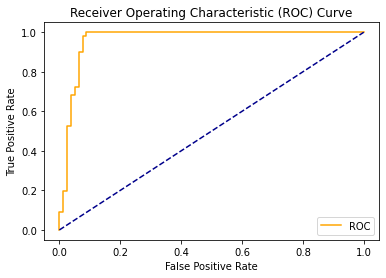

Test ROC
0.74411926179315
Threshold value is: 3.2313056


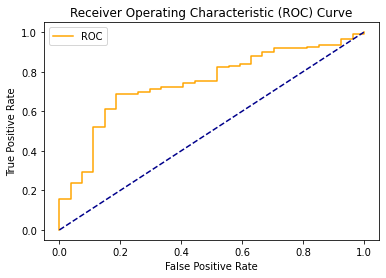


 
 =====================   Train Dataset    ======================
99.74179269642198
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95        79
         1.0       1.00      1.00      1.00      2632

    accuracy                           1.00      2711
   macro avg       1.00      0.96      0.98      2711
weighted avg       1.00      1.00      1.00      2711



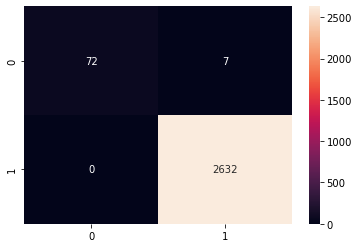

Accuracy of on training set: 1.00


 =====================   Test Dataset    =======================
69.24778761061947
              precision    recall  f1-score   support

         0.0       0.07      0.81      0.14        27
         1.0       0.99      0.69      0.81       877

    accuracy                           0.69       904
   macro avg       0.53      0.75      0.47       904
weighted avg       0.96      0.69      0.79       904



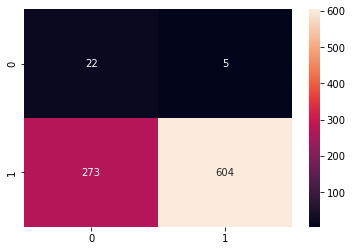

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.7441


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.81481481 0.68871152]
average accuracy:  0.7517631656742261
f1 0.8129205921938089


In [48]:
# xgboost - train with missing values


xgb_impute=XGBClassifier(
        use_label_encoder=False,
        eta = 0.1,#eta between(0.01-0.2)
        max_depth = 6, #values between(3-10)
#         max_delta_step = 10,
#         subsample = 0.5,#values between(0.5-1)
#         colsample_bytree = 1,#values between(0.5-1)
#         tree_method = "auto",
#         process_type = "default",
#         num_parallel_tree=7,
        objective='multi:softmax',
#         min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
        )
        
# xgb_impute.fit(X_train,Y_train)
xgb_impute = cross_val(xgb_impute,10)

# xgb_pred=xgb_impute.predict(X_test)
# xgb_pred_train=xgb_impute.predict(X_train)


# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(xgb_impute, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(xgb_impute, X_test, Y_test)

xgb_pred = (xgb_impute.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
xgb_pred_train = (xgb_impute.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(xgb_impute, X_train, Y_train, xgb_pred_train)
test_results(xgb_impute, X_test, Y_test, xgb_pred)

# ROC
ROC_results(xgb_impute, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(xgb_impute, Y_test, xgb_pred)



<AxesSubplot:>

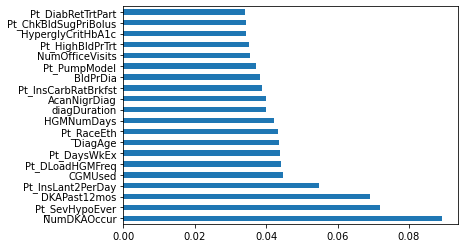

In [49]:
# feature importance graph of XGB
feat_importances = pd.Series(xgb_impute.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 2 - Random forest

Accuracy for the fold no. 1 on the test set: 0.9705882352941176, doublecheck: 0.9705882352941176
Accuracy for the fold no. 2 on the test set: 0.974169741697417, doublecheck: 0.974169741697417
Accuracy for the fold no. 3 on the test set: 0.966789667896679, doublecheck: 0.966789667896679
Accuracy for the fold no. 4 on the test set: 0.9630996309963099, doublecheck: 0.9630996309963099
Accuracy for the fold no. 5 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 6 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 7 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 8 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 9 on the test set: 0.966789667896679, doublecheck: 0.966789667896679
Accuracy for the fold no. 10 on the test set: 0.966789667896679, doublecheck: 0.966789667896679
Train ROC
0.9666759647570313
Threshol

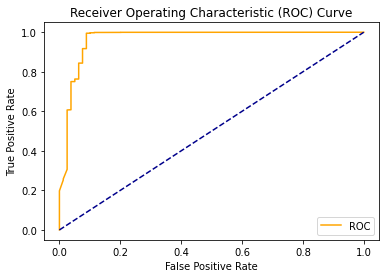

Test ROC
0.7465475737995692
Threshold value is: 0.9261561225860624


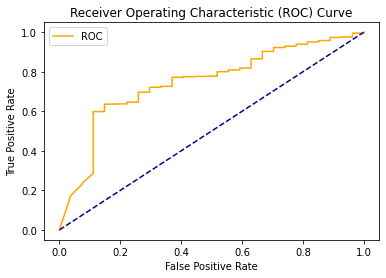


 
 =====================   Train Dataset    ======================
99.26226484691996
              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88        79
         1.0       1.00      1.00      1.00      2632

    accuracy                           0.99      2711
   macro avg       0.92      0.95      0.94      2711
weighted avg       0.99      0.99      0.99      2711



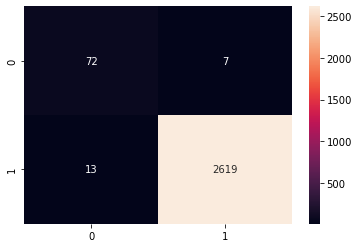

Accuracy of on training set: 1.00


 =====================   Test Dataset    =======================
64.26991150442478
              precision    recall  f1-score   support

         0.0       0.07      0.85      0.12        27
         1.0       0.99      0.64      0.78       877

    accuracy                           0.64       904
   macro avg       0.53      0.74      0.45       904
weighted avg       0.97      0.64      0.76       904



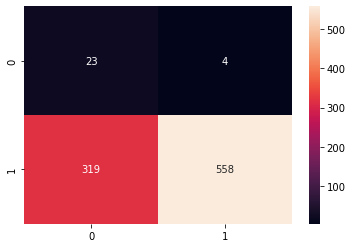

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.7465


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.85185185 0.63625998]
average accuracy:  0.7440559145234173
f1 0.7755385684503128


In [50]:
#  random forest classifier

rf=RandomForestClassifier(max_depth=10,
                             n_estimators = feature,
                             criterion = 'entropy', # {“gini”, “entropy”}, default=”gini”
                             class_weight = 'balanced_subsample', # {“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
                             ccp_alpha=0.001,
                             random_state=0)

# rf.fit(X_train,Y_train)
rf = cross_val(rf,10)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(rf, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(rf, X_test, Y_test)

# pred=rf.predict(X_test)
pred = (rf.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# pred_train=rf.predict(X_train)
pred_train = (rf.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(rf, X_train, Y_train, pred_train)
test_results(rf, X_test, Y_test, pred)

# ROC
ROC_results(rf, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(rf, Y_test, pred)

<AxesSubplot:>

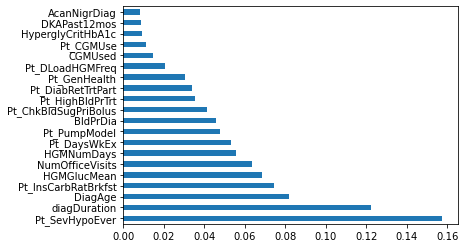

In [51]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

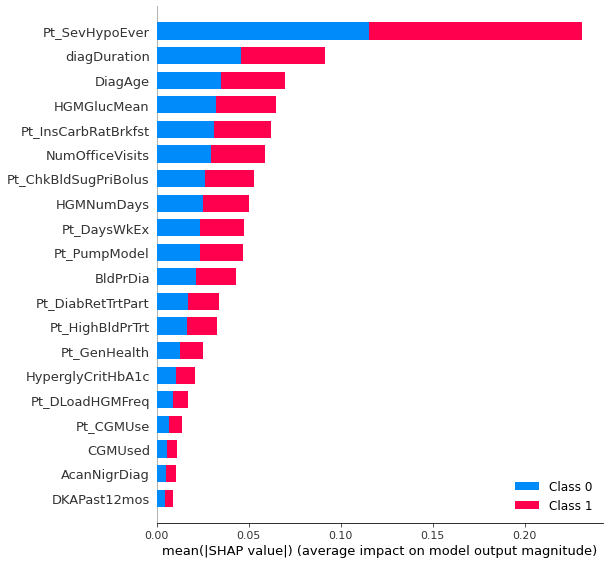

In [52]:
shap_values = shap.TreeExplainer(rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

## Model 3 LogisticRegression

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 1 on the test set: 0.6985294117647058, doublecheck: 0.6985294117647058
Accuracy for the fold no. 2 on the test set: 0.7675276752767528, doublecheck: 0.7675276752767528
Accuracy for the fold no. 3 on the test set: 0.7416974169741697, doublecheck: 0.7416974169741697


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 4 on the test set: 0.6715867158671587, doublecheck: 0.6715867158671587
Accuracy for the fold no. 5 on the test set: 0.7232472324723247, doublecheck: 0.7232472324723247
Accuracy for the fold no. 6 on the test set: 0.7195571955719557, doublecheck: 0.7195571955719557


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 7 on the test set: 0.6789667896678967, doublecheck: 0.6789667896678967
Accuracy for the fold no. 8 on the test set: 0.6974169741697417, doublecheck: 0.6974169741697417
Accuracy for the fold no. 9 on the test set: 0.6974169741697417, doublecheck: 0.6974169741697417
Accuracy for the fold no. 10 on the test set: 0.7195571955719557, doublecheck: 0.7195571955719557
Train ROC
0.7953426185987456
Threshold value is: 0.514715909824763


The max_iter was reached which means the coef_ did not converge


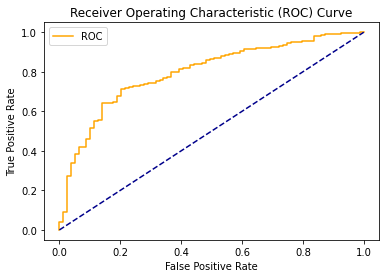

Test ROC
0.6499429874572407
Threshold value is: 0.710099416092638


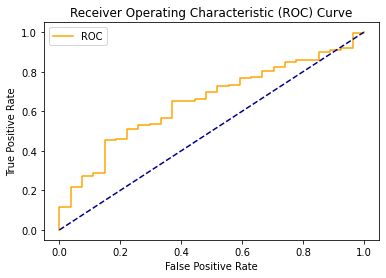


 
 =====================   Train Dataset    ======================
71.33898930284029
              precision    recall  f1-score   support

         0.0       0.08      0.80      0.14        79
         1.0       0.99      0.71      0.83      2632

    accuracy                           0.71      2711
   macro avg       0.53      0.75      0.48      2711
weighted avg       0.96      0.71      0.81      2711



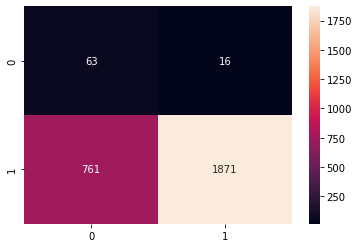

Accuracy of on training set: 0.73


 =====================   Test Dataset    =======================
46.902654867256636
              precision    recall  f1-score   support

         0.0       0.05      0.85      0.09        27
         1.0       0.99      0.46      0.63       877

    accuracy                           0.47       904
   macro avg       0.52      0.65      0.36       904
weighted avg       0.96      0.47      0.61       904



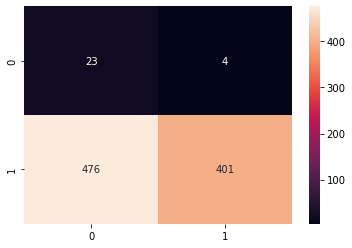

Accuracy of classifier on test set: 0.72


 =======================   Test-ROC    =========================
roc_auc = 0.6499


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.85185185 0.45724059]
average accuracy:  0.6545462223911482
f1 0.625585023400936


In [53]:
#penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
logreg = LogisticRegression(
    penalty='l2',
    tol = 5e-4,
    C=1,
    l1_ratio = 10,
    class_weight='balanced',  # balanced
    random_state=0,
    solver = 'saga' # saga, sag
)

# logreg.fit(X_train, Y_train)
logreg = cross_val(logreg,10)

# pred=logreg.predict(X_test)
# pred_train=logreg.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(logreg, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(logreg, X_test, Y_test)

pred = (logreg.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (logreg.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(logreg, X_train, Y_train, pred_train)
test_results(logreg, X_test, Y_test, pred)

# ROC
ROC_results(logreg, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(logreg, Y_test, pred)

<AxesSubplot:>

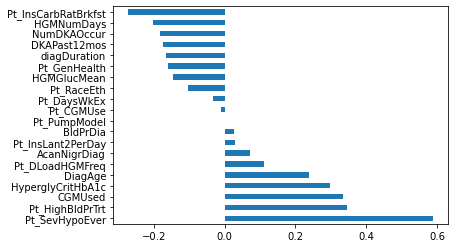

In [54]:

feat_importances = pd.Series(logreg.coef_[0], index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 6 - Linear Discriminant Analysis

Accuracy for the fold no. 1 on the test set: 0.9595588235294118, doublecheck: 0.9595588235294118
Accuracy for the fold no. 2 on the test set: 0.977859778597786, doublecheck: 0.977859778597786
Accuracy for the fold no. 3 on the test set: 0.966789667896679, doublecheck: 0.966789667896679
Accuracy for the fold no. 4 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 5 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 6 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 7 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 8 on the test set: 0.959409594095941, doublecheck: 0.959409594095941
Accuracy for the fold no. 9 on the test set: 0.955719557195572, doublecheck: 0.955719557195572
Accuracy for the fold no. 10 on the test set: 0.9630996309963099, doublecheck: 0.9630996309963099
Train ROC
0.7750423223423492
Threshol

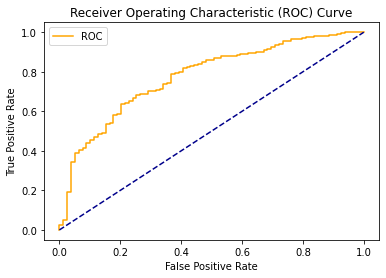

Test ROC
0.6450019004180919
Threshold value is: 0.989633130693131


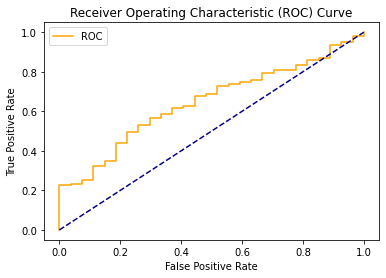


 
 =====================   Train Dataset    ======================
63.961637772039836
              precision    recall  f1-score   support

         0.0       0.06      0.80      0.11        79
         1.0       0.99      0.63      0.77      2632

    accuracy                           0.64      2711
   macro avg       0.53      0.72      0.44      2711
weighted avg       0.96      0.64      0.75      2711



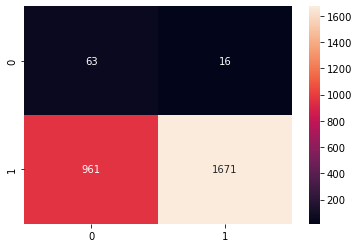

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
50.442477876106196
              precision    recall  f1-score   support

         0.0       0.05      0.78      0.09        27
         1.0       0.99      0.50      0.66       877

    accuracy                           0.50       904
   macro avg       0.52      0.64      0.37       904
weighted avg       0.96      0.50      0.64       904



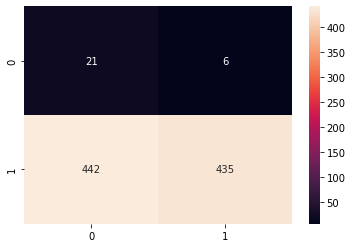

Accuracy of classifier on test set: 0.96


 =======================   Test-ROC    =========================
roc_auc = 0.645


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.77777778 0.49600912]
average accuracy:  0.6368934498923097
f1 0.6600910470409712


In [55]:

lda = LinearDiscriminantAnalysis(
    solver = 'eigen', # solver{‘svd’, ‘lsqr’, ‘eigen’}, default=’svd’
    shrinkage= 'auto', #shrinkage‘auto’ or float, default=None
    n_components = 1,
    tol = 1e-3                       
)
# lda.fit(X_train, Y_train)
lda = cross_val(lda)

# pred=lda.predict(X_test)
# pred_train=lda.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(lda, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(lda, X_test, Y_test)

pred = (lda.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (lda.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(lda, X_train, Y_train, pred_train)
test_results(lda, X_test, Y_test, pred)

# ROC
ROC_results(lda, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(lda, Y_test, pred)


## Model 7- Gaussian Naive Bayes

Accuracy for the fold no. 1 on the test set: 0.9411764705882353, doublecheck: 0.9411764705882353
Accuracy for the fold no. 2 on the test set: 0.9704797047970479, doublecheck: 0.9704797047970479
Accuracy for the fold no. 3 on the test set: 0.966789667896679, doublecheck: 0.966789667896679
Accuracy for the fold no. 4 on the test set: 0.9630996309963099, doublecheck: 0.9630996309963099
Accuracy for the fold no. 5 on the test set: 0.9630996309963099, doublecheck: 0.9630996309963099
Accuracy for the fold no. 6 on the test set: 0.9630996309963099, doublecheck: 0.9630996309963099
Accuracy for the fold no. 7 on the test set: 0.9630996309963099, doublecheck: 0.9630996309963099
Accuracy for the fold no. 8 on the test set: 0.9372693726937269, doublecheck: 0.9372693726937269
Accuracy for the fold no. 9 on the test set: 0.9520295202952029, doublecheck: 0.9520295202952029
Accuracy for the fold no. 10 on the test set: 0.9630996309963099, doublecheck: 0.9630996309963099
Train ROC
0.7560116963564311
Th

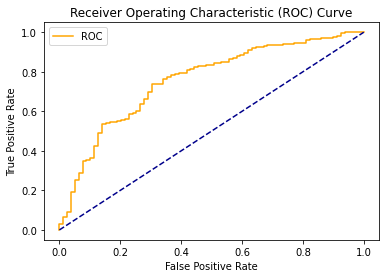

Test ROC
0.6627813674563959
Threshold value is: 0.9943467202484697


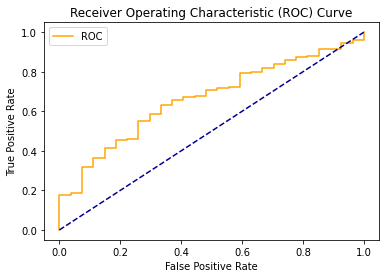


 
 =====================   Train Dataset    ======================
73.51530800442642
              precision    recall  f1-score   support

         0.0       0.07      0.70      0.13        79
         1.0       0.99      0.74      0.84      2632

    accuracy                           0.74      2711
   macro avg       0.53      0.72      0.49      2711
weighted avg       0.96      0.74      0.82      2711



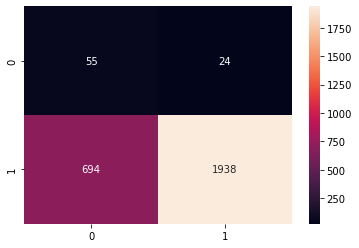

Accuracy of on training set: 0.96


 =====================   Test Dataset    =======================
63.16371681415929
              precision    recall  f1-score   support

         0.0       0.05      0.67      0.10        27
         1.0       0.98      0.63      0.77       877

    accuracy                           0.63       904
   macro avg       0.52      0.65      0.43       904
weighted avg       0.96      0.63      0.75       904



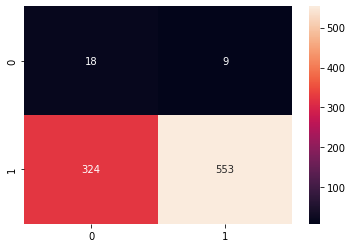

Accuracy of classifier on test set: 0.95


 =======================   Test-ROC    =========================
roc_auc = 0.6628


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.66666667 0.63055872]
average accuracy:  0.6486126947928543
f1 0.7685892981236969


In [56]:
gnb = GaussianNB(priors=None, var_smoothing=1)
gnb = cross_val(gnb)
# gnb.fit(X_train, Y_train)
      
# pred=gnb.predict(X_test)
# pred_train=gnb.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(gnb, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(gnb, X_test, Y_test)

pred = (gnb.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (gnb.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(gnb, X_train, Y_train, pred_train)
test_results(gnb, X_test, Y_test, pred)

# ROC
ROC_results(gnb, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(gnb, Y_test, pred)
